# Indoor Care Chatbot (YOLO + ChatGPT)

### Load the previously prepared OpenVINO optimized YOLOv8 model

In [1]:
from openvino.runtime import Core
core = Core()
# Load the pre optimized model
yolov8n_with_preprocess_model = core.read_model('models/yolov8n_openvino_int8_model/yolov8n_with_preprocess.xml',)

import json
# Load the label map
with open('models/yolov8n_labels.json', 'r') as f:
    label_map = json.load(f)
    label_map = {int(k): v for k, v in label_map.items()}

# Camera source could be different for different systems, please test with `run_object_detection` function
CAMERA_SOURCE = 0
# distance_confidence_matrix, all_detected_objects = run_object_detection(source=0, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)

### Setup YOLO Chat!

We are going to use an OpenAI Chat function `identify_object` and `identify_specific_object` BUT with few message templates to get some better responses

In [2]:
def view_camera_remover(all_detected_objects):
    if 'view_camera' in all_detected_objects:
        # remove the view camera from the list of detected objects
        all_detected_objects.remove('view_camera')
    return all_detected_objects

def identify_object(object_name, distance_confidence_matrix, all_detected_objects):
    all_detected_objects = view_camera_remover(all_detected_objects)
    if len(all_detected_objects) != 0:
        return "Teach the user more about all the objects here: " + ", ".join(all_detected_objects)
    return "No objects found in the scene"

def identify_specific_object(object_name, distance_confidence_matrix, all_detected_objects):
    all_detected_objects = view_camera_remover(all_detected_objects)
    if len(all_detected_objects) != 0:
        if object_name in all_detected_objects:
             return "Yes, " + object_name + " is present in the scene"
        else:
            return "No, " + object_name + " is not present in the scene"
    return "No objects found in the scene"

#### Setup the Chat config with the YOLO model, functions and jupyter widgets

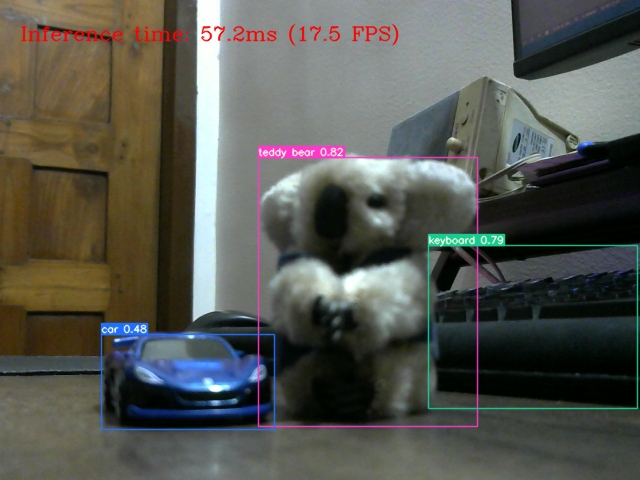

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

In [ ]:
import os
import openai
import json
from dotenv import load_dotenv
from datetime import datetime
from IPython.display import HTML, display
from ipywidgets import widgets, Output

from utils.objectDetect import run_object_detection

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

label_map_values = list(label_map.values())

# model = "gpt-3.5-turbo-0613"
model = "gpt-4-0613"

functions = [
        {
            "name": "identify_specific_object",
            "description": "Find if a specific object asked by the user is present in the scene",
            "parameters": {
                "type": "object",
                "properties": {
                    "object_name": {
                        "type": "string",
                        "description": "The object to find",
                        "enum": label_map_values
                    },
                },
                "required": ["object_name"],
            }
        },
        {
            "name": "identify_object",
            "description": "Identify all the objects present in the scene",
            "parameters": {
                "type": "object",
                "properties": {},
            }
        }
    ]

# Define available functions names
available_functions = {
    "identify_specific_object": identify_specific_object,
    "identify_object": identify_object
}

# Define widget for UI
in_text = widgets.Text()
in_text.placeholder = "Type your message here, press enter to send."
in_text.add_class("form-control bg-light text-dark border border-primary rounded bg-light")
in_text.continuous_update = False
output = widgets.Output()

# Chat history
chat_history = [
    {
        "role": "system", 
        "content": """ You are a fun assistant for 5yr old kids.
You have to help them understand and learn about daily objects.
You are connected to a YOLO Camera.
You are obviously placed in a room."""
    }
]

def user_question(question):
    return f'''<div class="chat-message-right pb-4"><div>
        <img src="images/bear.png" class="rounded-circle mr-1" width="40" height="40">
        <div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>
        <div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">
        <div class="font-weight-bold mb-1">You</div>{question}</div>'''

def system_response(answer_formatted):
    return f'''<div class="chat-message-left pb-4"><div>'
        <img src="images/cat.png" class="rounded-circle mr-1" width="40" height="40">
        <div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>
        <div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">
        <div class="font-weight-bold mb-1">Scene Explorer (YOLO Chat)</div>{answer_formatted}</div>'''

    
def chat_wrapper(messages, functions=[]):
    if functions != []:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            functions=functions,
            function_call="auto",  # auto is default, but we'll be explicit
        )
        return response["choices"][0]["message"]
    else:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
        )
        return response["choices"][0]["message"]

def text_eventhandler(*args):
    # Needed bc when we "reset" the text input
    # it fires instantly another event since
    # we "changed" it's value to ""
    if args[0]["new"] == "":
        return
    # Show loading animation
    loading_bar.layout.display = "block"
    # Get question
    question = args[0]["new"]
    # Reset text field
    args[0]["owner"].value = ""
    # Formatting question for output
    q = (user_question(question))
    # Display formatted question
    output.append_display_data(HTML(q))
    function_chat_history = chat_history.copy()
    function_chat_history.append({"role": "user", "content": question})
    response_message = chat_wrapper(function_chat_history, functions=functions)
    if response_message.get("function_call"):
        function_name = response_message["function_call"]["name"]
        function_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        distance_confidence_matrix, all_detected_objects = run_object_detection(source=CAMERA_SOURCE, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)
        function_response = function_to_call(
            object_name=function_args.get("object_name"),
            distance_confidence_matrix=distance_confidence_matrix,
            all_detected_objects=all_detected_objects
        )
        chat_history.append(response_message)
        chat_history.append({"role": "function", "name": function_name, "content": function_response})
    answer = chat_wrapper(chat_history)["content"]
    # Formatting answer for output
    # Replacing all $ otherwise matjax would format them in a strange way
    answer_formatted = answer.replace("$", r"\$")
    chat_history.append({"role": "assistant", "content": answer_formatted})
    a = (system_response(answer_formatted))
    # Turn off loading animation
    loading_bar.layout.display = "none"
    output.append_display_data(HTML(a))

in_text.observe(text_eventhandler, "value")

def button_eventhandler(message):
    # Show loading animation
    loading_bar.layout.display = "block"
    # Get question
    question = message
    q = (user_question(question))
    # Display formatted question
    output.append_display_data(HTML(q))
    # prep chat history
    chat_history.append({"role": "user", "content": question})
    answer = chat_wrapper(chat_history)["content"]
    answer_formatted = answer.replace("$", r"\$")
    chat_history.append({"role": "assistant", "content": answer_formatted})
    a = (system_response(answer_formatted))
    # Turn off loading animation
    loading_bar.layout.display = "none"
    output.append_display_data(HTML(a))


# Loading animation
file = open("images/loading.gif", "rb")
image = file.read()
loading_bar = widgets.Image(
    value=image, format="gif", width="20", height="20", layout={"display": "None"}
)

# clear display and chat history
clear_button = widgets.Button(description="Clear the chat history")
clear_button.layout.margin = "0px 0px 0px auto"
def reset_display(*args):
    output.clear_output()
    chat_history[:] = chat_history[:1]
    display(hbox_widgets)
    display(box_widget)
clear_button.on_click(reset_display)

# Explain objects in the scene (prompt button)
explain_button = widgets.Button(description="Explain all objects")
clear_button.layout.margin = "0px 0px 0px auto"
def explain_objects(*args):
    distance_confidence_matrix, all_detected_objects = run_object_detection(source=CAMERA_SOURCE, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)
    all_detected_objects = view_camera_remover(all_detected_objects)
    all_objects = ", ".join(all_detected_objects)
    query = f"Teach me more about the objects here: {all_objects}"
    button_eventhandler(query)
explain_button.on_click(explain_objects)

# Create a fun story (prompt button)
story_button = widgets.Button(description="Tell me a fun story about the objects")
clear_button.layout.margin = "0px 0px 0px auto"
def tell_story(*args):
    distance_confidence_matrix, all_detected_objects = run_object_detection(source=CAMERA_SOURCE, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)
    all_detected_objects = view_camera_remover(all_detected_objects)
    all_objects = ", ".join(all_detected_objects)
    query = f"Teach me more about the objects by telling me a fun story with the objects: {all_objects}"
    button_eventhandler(query)
story_button.on_click(tell_story)

# Define UI
hbox_widgets = widgets.HBox(
                    [output],
                    layout=widgets.Layout(
                        width="100%",
                        max_height="500px",
                        display="inline-flex",
                        flex_flow="column-reverse",
                    ),
                )

box_widget = widgets.Box(
                children=[loading_bar, in_text, explain_button, story_button, clear_button],
                layout=widgets.Layout(display="flex", flex_flow="row"),
            )

### Start the Chat

In [7]:
# Init display
reset_display()

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

Run the cell below to fix the styling of the chat interface

In [8]:
%%html
<link rel="stylesheet" 
      href="https://cdn.jsdelivr.net/npm/bootstrap@4.5.3/dist/css/bootstrap.min.css" 
      integrity="sha384-TX8t27EcRE3e/ihU7zmQxVncDAy5uIKz4rEkgIXeMed4M0jlfIDPvg6uqKI2xXr2" 
      crossorigin="anonymous">
<style>
    body{
        margin-top:20px;
        background-color: #2b2b2b; /* Dark background color */
        color: #2b2b2b; /* Light font color */
    }

    .chat-message-left,
    .chat-message-right {
        display: flex;
        flex-shrink: 0
    }

    .chat-message-left {
        margin-right: auto
    }

    .chat-message-right {
        flex-direction: row-reverse;
        margin-left: auto
    }
</style>